#Machine Learning Project - Assignmnet 11
##Convolutional Neural Network for the classification task on MNIST
###CAUCSE senior 20151145 Kim Jekyun

##Computing Area

###0. Preset

In [50]:
## Import required libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import math
%matplotlib inline

###1. Data

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [52]:
data_path = './MNIST'

testing_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
training_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

print("the number of your training data (must be 10,000) = ", training_set.__len__())
print("the number of your testing data (must be 60,000) = ", testing_set.__len__())

the number of your training data (must be 10,000) =  10000
the number of your testing data (must be 60,000) =  60000


###2. Model

In [53]:
class MyModel(nn.Module):

    def __init__(self, num_classes=10, size_kernel=5):

        super(MyModel, self).__init__()
        # *********************************************************************
        # input parameter
        # data size:
        #   mnist   : 28 * 28
        # *********************************************************************
        self.number_class   = num_classes
        self.size_kernel    = size_kernel        
        
        # *********************************************************************
        # feature layer
        # *********************************************************************
        self.conv1          = nn.Conv2d(1, 20, kernel_size=size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)
        self.conv2          = nn.Conv2d(20, 50, kernel_size=size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)

        self.conv_layer1    = nn.Sequential(self.conv1, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))
        self.conv_layer2    = nn.Sequential(self.conv2, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))

        self.feature        = nn.Sequential(self.conv_layer1, self.conv_layer2)
        
        # *********************************************************************
        # classifier layer
        # *********************************************************************
        self.fc1        = nn.Linear(50*7*7, 50, bias=True)
        self.fc2        = nn.Linear(50, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))

        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2)
        
        self._initialize_weight()        

        
    def _initialize_weight(self):

        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):                
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [65]:
# Definition of hyper parameters
learning_rate_value = 0.000001
batch_size = 64
epochs = 50

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

###3. Loss function

In [66]:
criterion = nn.NLLLoss().to(device)

###4. Optimization

In [67]:
# Dataloader & Optimizer
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)

classifier = MyModel().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate_value)

In [68]:
# Training - Gradient Descent
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    train_loss_tmp = 0
    train_acc_tmp = 0
    length = 0
    n = 0

    classifier.train()
    for data, target in training_loader:
        data, target = data.to(device), target.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward
        output = classifier(data).to(device)
        #print(target.shape)
        loss = criterion(output, target).to(device)
        # Backword
        loss.backward()
        # Loss
        train_loss_tmp += loss
        length += len(data)
        n += 1
        # Update
        optimizer.step()
        # Accuracy
        result = output.argmax(dim=1, keepdim=True)
        accuracy = result.eq(target.view_as(result)).sum()
        train_acc_tmp += accuracy
    
    train_loss.append(train_loss_tmp / n)
    train_acc.append(train_acc_tmp / length)
    if epoch%10 == 0:
        print('Training - Epoch : {}, Loss : {}, Accuracy : {}'.format(epoch, train_loss[-1], train_acc[-1]))

    test_loss_tmp = 0
    test_acc_tmp = 0
    length = 0
    n = 0
    
    classifier.eval()
    with torch.no_grad():
        for data, target in testing_loader:
            data, target = data.to(device), target.to(device)
            # Forward
            output = classifier(data).to(device)
            loss = criterion(output, target).to(device)
            # Loss
            test_loss_tmp += loss
            length += len(data)
            n += 1
            # Accuracy
            result = output.argmax(dim=1, keepdim=True)
            accuracy = result.eq(target.view_as(result)).sum()
            test_acc_tmp += accuracy
    
    test_loss.append(test_loss_tmp / n)
    test_acc.append(test_acc_tmp / length)
    if epoch%25 == 0:
        print('Testing - Epoch : {}, Loss : {}, Accuracy : {}'.format(epoch, test_loss[-1], test_acc[-1]))

Training - Epoch : 0, Loss : -0.0039872233755886555, Accuracy : 0.11216162890195847
Testing - Epoch : 0, Loss : -0.004188304767012596, Accuracy : 0.12186834216117859
Training - Epoch : 10, Loss : -0.00454485509544611, Accuracy : 0.11335588991641998
Training - Epoch : 20, Loss : -0.0051619503647089005, Accuracy : 0.11644108593463898
Testing - Epoch : 25, Loss : -0.005694207269698381, Accuracy : 0.126332625746727
Training - Epoch : 30, Loss : -0.005849380977451801, Accuracy : 0.1177348718047142


KeyboardInterrupt: ignored

In [58]:
train_loss_tot = train_loss[-1]
test_loss_tot = test_loss[-1]
train_acc_tot = train_acc[-1]
test_acc_tot = test_acc[-1]

In [59]:
ind = ['training', 'testing']
con_loss = {'loss':ind, '':[train_loss_tot.item(), test_loss_tot.item()]}
con_acc = {'accuracy':ind, '':[train_acc_tot.item(), test_acc_tot.item()]}

tot_loss = pd.DataFrame(con_loss).set_index('loss')
tot_acc = pd.DataFrame(con_acc).set_index('accuracy')

---
##Result Area

###1. Plot the training and testing losses over epochs

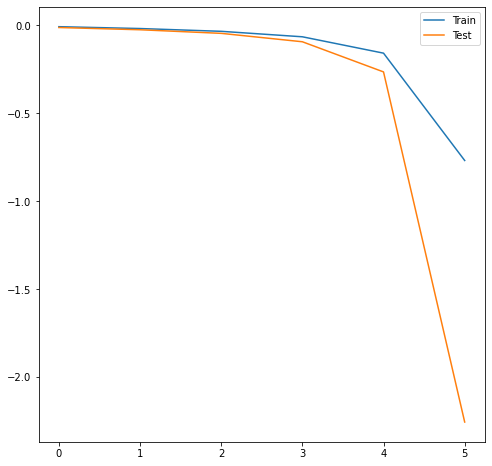

In [60]:
plt.figure(figsize=(8,8))
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Train', 'Test'])
plt.show()

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###2. Plot the training and testing accuracies over epochs

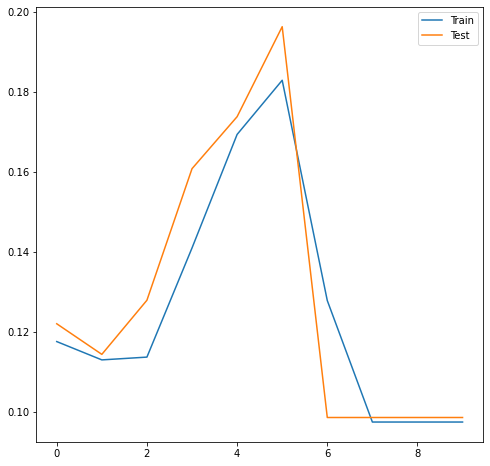

In [61]:
plt.figure(figsize=(8,8))
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['Train', 'Test'])
plt.show()

###3. Print the final training and testing losses at convergence

In [62]:
tot_loss

,
loss,
training,NaN
testing,NaN


###4. Print the final training and testing accuracies at convergence

In [63]:
tot_acc

,
accuracy,
training,0.097532
testing,0.098664


###5. Print the testing accuracies within the last 10 epochs